In [6]:
import re
import json
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [7]:
%matplotlib inline

In [18]:
def parse_metrics_from_log(filepath: Path) -> pd.DataFrame:
    """
    Parses a QUICHE log file, extracting all METRICS_LOG JSON blobs.
    
    Args:
        filepath: The Path object to the log file.

    Returns:
        A pandas DataFrame containing all metrics, or an empty DataFrame
        if no metrics are found.
    """
    # Regex to find the JSON blob in lines containing METRICS_LOG
    # It handles both "Client: METRICS_LOG {json}" and "Server: METRICS_LOG {json}"
    metrics_regex = re.compile(r'METRICS_LOG ({.*})')
    
    metrics_data = []
    
    try:
        with open(filepath, 'r') as f:
            for line in f:
                match = metrics_regex.search(line)
                if match:
                    try:
                        # Extract and parse the JSON blob
                        data = json.loads(match.group(1))
                        metrics_data.append(data)
                    except json.JSONDecodeError:
                        print(f"Warning: Skipping malformed JSON in {filepath.name}", file=sys.stderr)
                        
    except IOError as e:
        print(f"Error reading file {filepath}: {e}", file=sys.stderr)
        return pd.DataFrame()

    if not metrics_data:
        print(f"Warning: No metrics found in {filepath.name}", file=sys.stderr)
        
    return pd.DataFrame(metrics_data)

def plot_metrics(
    files: list[Path], 
    metric_key: str, 
    y_label: str, 
    title: str, 
    output_filename: str,
    scale_factor: float = 1.0,
    smoothing_window: int = 1  # New parameter for rolling average
):
    """
    Generates and saves a plot for a specific metric from a list of log files.

    Args:
        files: A list of log file Path objects to plot.
        metric_key: The key to extract from the metrics (e.g., "goodput_bps").
        y_label: The label for the Y-axis.
        title: The title for the plot.
        output_filename: The filename to save the plot as.
        scale_factor: A factor to scale the metric by (e.g., 1/1_000_000 for Mbps).
        smoothing_window: The window size for a rolling average. 1 = no smoothing.
    """
    plt.figure(figsize=(15, 7))
    label_to_name = {
        'QBIC': 'Cubic',
        'BBRR': 'BBR',
        'B2ON': 'BBRv3',
        'LLMX': 'Ours',
        'PRGC': 'Prague'
    }
    
    for filepath in files:
        # Create a clean label from the filename
        # e.g., "client_1_QBIC.txt" -> "1_QBIC"
        # e.g., "server_1.txt" -> "server_1"
        label = filepath.stem.replace("client_", "")
        
        df = parse_metrics_from_log(filepath)
        
        if not df.empty and metric_key in df.columns:
            # Ensure data is sorted by time and reset index
            df = df.sort_values(by='time_ms').reset_index()
            
            # Normalize time to start from 0 for all flows
            if 'time_ms' in df.columns:
                # df['time_sec'] = (df['time_ms'] - df['time_ms'].min()) / 1000
                df['time_sec'] = (df['time_ms']) / 1000
                
                # Apply scaling
                df['metric_scaled'] = df[metric_key] * scale_factor
                
                # Apply rolling average for smoothing if window > 1
                if smoothing_window > 1:
                    # Use min_periods=1 to get data even at the beginning
                    # center=True makes the average non-causal but more accurate
                    df['metric_smoothed'] = df['metric_scaled'].rolling(
                        window=smoothing_window, min_periods=1, center=True
                    ).mean()
                    plot_data_key = 'metric_smoothed'
                else:
                    plot_data_key = 'metric_scaled'
                
                # Plot the smoothed (or non-smoothed) data
                plt.plot(df['time_sec'].to_numpy(), df[plot_data_key].to_numpy(), label=label, alpha=0.8, lw=2)

    # constrain plots
    #plt.xlim(0, 300)
    if metric_key == 'goodput_bps':
        plt.ylim(0, 4)
        plt.axhline(y=12/5, color='r', linestyle='--', linewidth=2, label='Fair BW')

    plt.title(title, fontsize=16)
    plt.xlabel("Time (seconds)", fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    
    try:
        plt.savefig(output_filename)
        print(f"Successfully generated plot: {output_filename}")
    except IOError as e:
        print(f"Error saving plot {output_filename}: {e}", file=sys.stderr)
    
    plt.show()

def calculate_jains_fairness_index(values: pd.Series) -> float:
    """
    Calculates Jain's Fairness Index for a pandas Series of values (e.g., goodputs).
    JFI = (sum(x_i))^2 / (n * sum(x_i^2))
    """
    x = values.to_numpy()
    n = len(x)
    
    if n == 0:
        return 1.0  # Trivial case: no flows

    sum_x = np.sum(x)
    sum_x_sq = np.sum(x**2)
    
    denominator = n * sum_x_sq
    
    if denominator == 0:
        # This implies all x_i are 0, which is perfectly "fair"
        return 1.0
        
    numerator = sum_x ** 2
    jfi = numerator / denominator
    return jfi

def plot_jains_fairness(
    client_files: list[Path],
    output_filename: str,
    smoothing_window: int = 1
):
    """
    Parses all client logs, calculates JFI over time, and plots it.
    """
    all_flows = []
    
    for filepath in client_files:
        df = parse_metrics_from_log(filepath)
        if not df.empty and 'goodput_bps' in df.columns:
            df['time_sec'] = df['time_ms'] / 1000
            flow_name = filepath.stem.replace("client_", "")
            
            # Create a Series with time as index and goodput as values
            flow_series = df.set_index('time_sec')['goodput_bps'].rename(flow_name)
            all_flows.append(flow_series)

    if not all_flows:
        print("Error: No client goodput data found to calculate JFI.", file=sys.stderr)
        return

    # Combine all flows into one DataFrame.
    # This aligns them by time_sec, creating NaNs where flows don't overlap.
    combined_df = pd.concat(all_flows, axis=1)
    
    # Sort by time index
    combined_df = combined_df.sort_index()
    
    # Forward-fill NaNs (assume goodput is constant until next report)
    # Then, fill remaining NaNs (at the very beginning) with 0.0
    combined_df = combined_df.ffill().fillna(0.0)

    # Calculate JFI for each row (each timestamp)
    jfi_series = combined_df.apply(calculate_jains_fairness_index, axis=1)

    # Apply smoothing to the final JFI series
    if smoothing_window > 1:
        jfi_to_plot = jfi_series.rolling(
            window=smoothing_window, min_periods=1, center=True
        ).mean()
        plot_label = f'JFI (Smoothed, window={smoothing_window})'
    else:
        jfi_to_plot = jfi_series
        plot_label = 'JFI (Raw)'

    # --- Plotting ---
    plt.figure(figsize=(15, 7))
    plt.plot(jfi_to_plot.index.to_numpy(), jfi_to_plot.values, label=plot_label, color='b', lw=2)

    plt.title("Jain's Fairness Index (JFI) over Time", fontsize=16)
    plt.xlabel("Time (seconds)", fontsize=12)
    plt.ylabel("Jain's Fairness Index (0.0 to 1.0)", fontsize=12)
    plt.ylim(0, 1.1)  # JFI is bounded [0, 1]
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.xlim(0,300)

    try:
        plt.savefig(output_filename)
        print(f"Successfully generated plot: {output_filename}")
    except IOError as e:
        print(f"Error saving plot {output_filename}: {e}", file=sys.stderr)
    
    plt.show()

Seaborn style not available, using default.


Found 5 client logs and 5 server logs.
Successfully generated plot: client_goodput.png


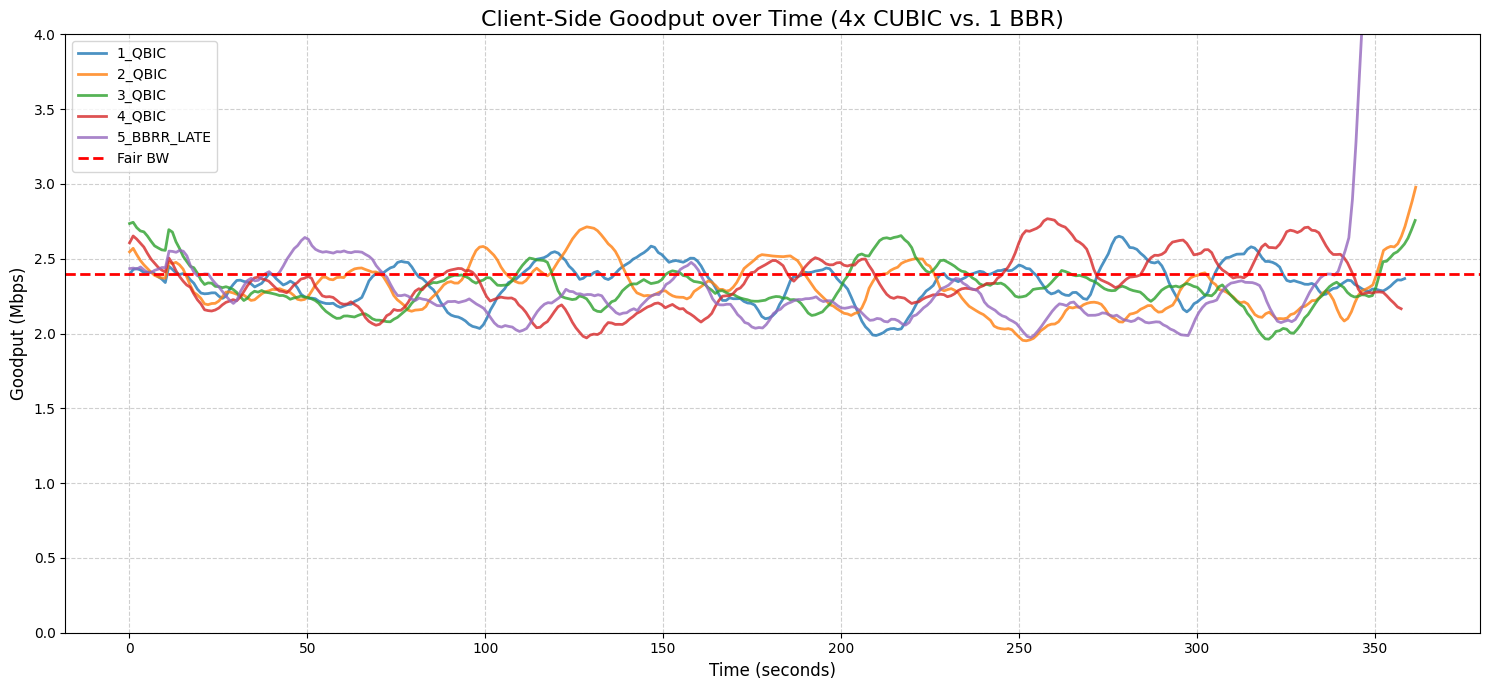

Successfully generated plot: server_cwnd.png


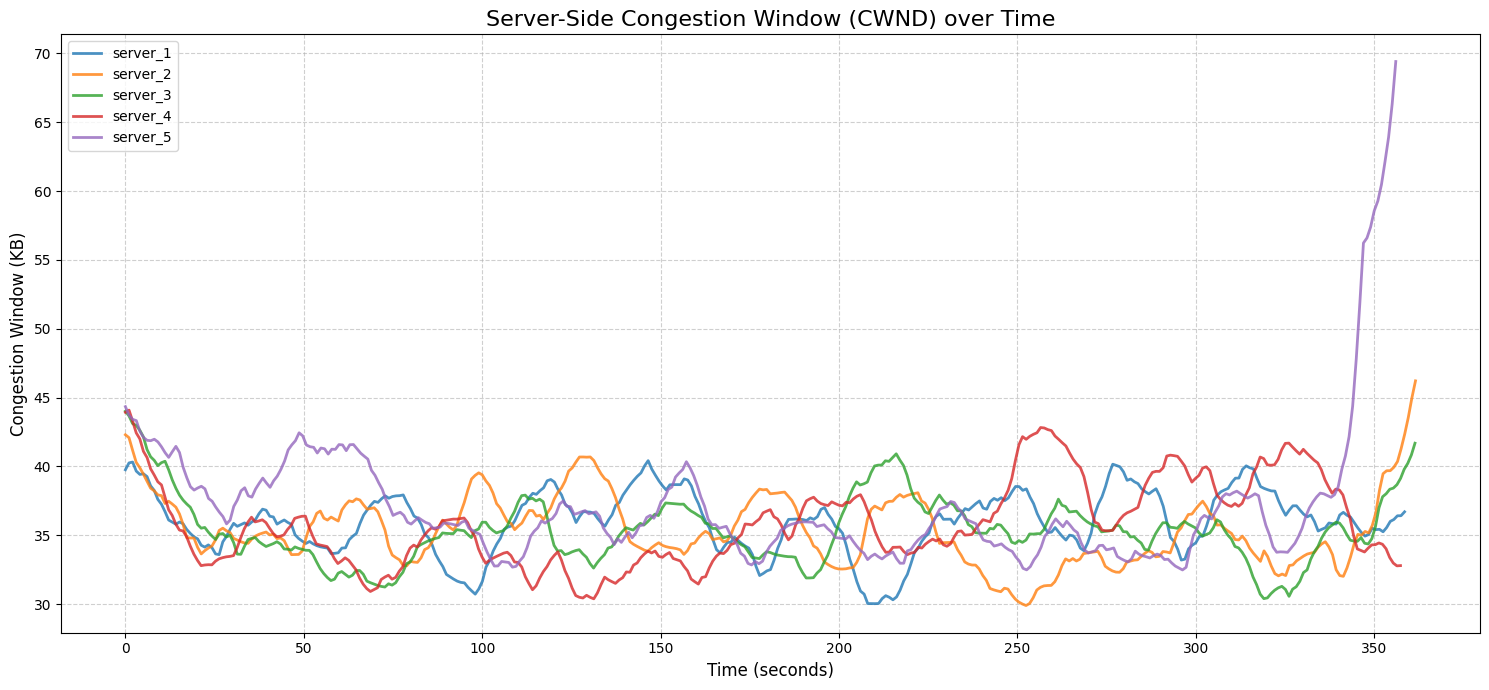

Successfully generated plot: client_srtt.png


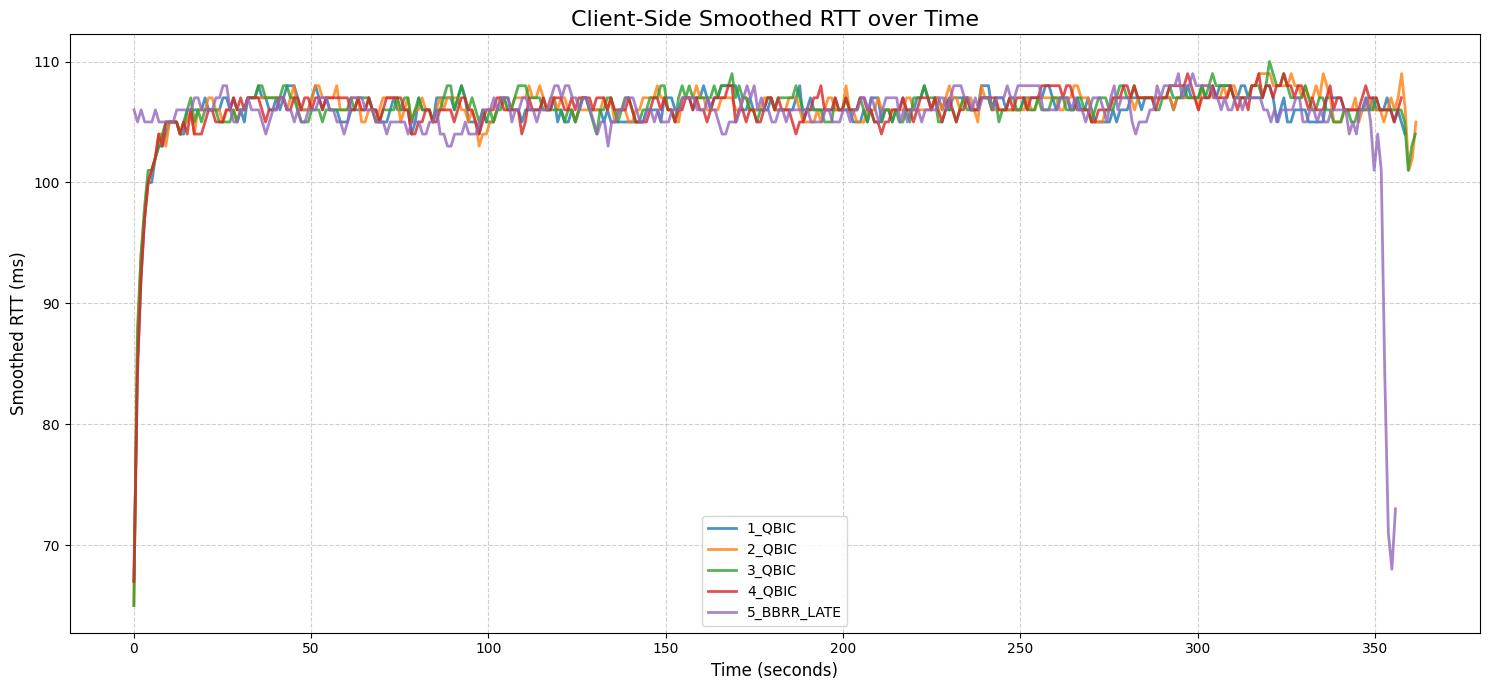

Successfully generated plot: jains_fairness_index.png


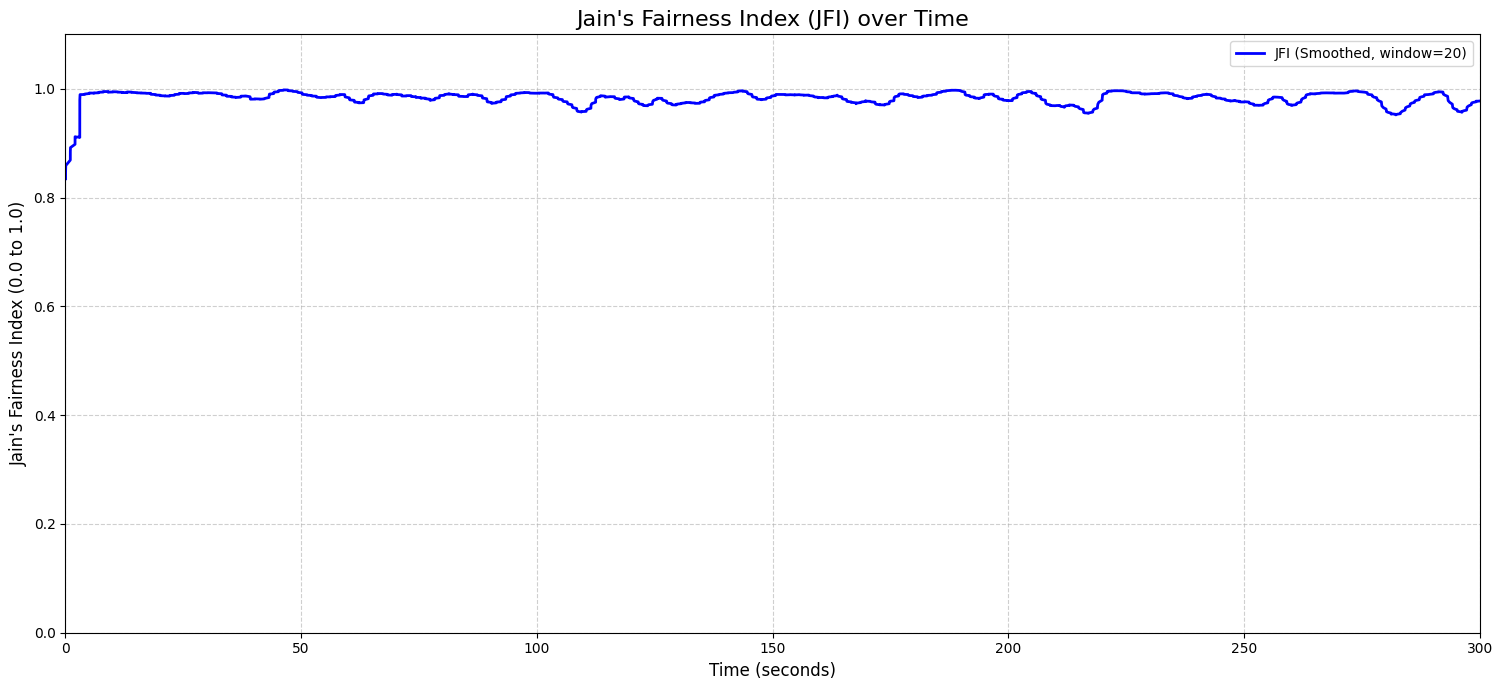

In [19]:
# Use seaborn style for better-looking plots
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except IOError:
    print("Seaborn style not available, using default.", file=sys.stderr)

# log_dir = Path("./LLMX_latecomer") # Assumes script is run in the log directory
log_dir = Path("./BBRR_latecomer") # Assumes script is run in the log directory

# Find all client and server log files in the current directory
client_files = sorted(log_dir.glob("client_*_*.txt"))
server_files = sorted(log_dir.glob("server_*.txt"))

if not client_files or not server_files:
    print(f"Error: No log files found in {log_dir.resolve()}", file=sys.stderr)
    print("Please run this script inside the log directory created by the experiment.", file=sys.stderr)
    print("Looking for 'client_X_*.txt' and 'server_X.txt' files.", file=sys.stderr)
    sys.exit(1)

print(f"Found {len(client_files)} client logs and {len(server_files)} server logs.")

# 1. Plot Client Goodput
plot_metrics(
    files=client_files,
    metric_key="goodput_bps",
    y_label="Goodput (Mbps)",
    title="Client-Side Goodput over Time (4x CUBIC vs. 1 BBR)",
    output_filename="client_goodput.png",
    scale_factor=1 / 1_000_000,  # Convert bps to Mbps
    smoothing_window=20
)

# 2. Plot Server CWND
plot_metrics(
    files=server_files,
    metric_key="cwnd_bytes",
    y_label="Congestion Window (KB)",
    title="Server-Side Congestion Window (CWND) over Time",
    output_filename="server_cwnd.png",
    scale_factor=1 / 1024,  # Convert bytes to KB
    smoothing_window=20
)

# 3. Plot Client Smoothed RTT (Bonus Plot)
plot_metrics(
    files=client_files,
    metric_key="srtt_ms",
    y_label="Smoothed RTT (ms)",
    title="Client-Side Smoothed RTT over Time",
    output_filename="client_srtt.png",
    scale_factor=1.0  # Already in ms
)

plot_jains_fairness(
    client_files=client_files,
    output_filename="jains_fairness_index.png",
    smoothing_window=20  # Use same smoothing as other plots
)